In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-2.4.4'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [3]:
users = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/users.csv")\
.persist()

In [4]:
movies = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/movie.csv")\
.persist()

In [5]:
ratings = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/rating.csv")\
.persist()

In [6]:
from pyspark.sql.functions import split, explode

popular_age_genres = users.alias("t1")\
.join(ratings.alias("t2"), col("t1.user_id") == col("t2.userId"))\
.join(movies.alias("t3"), col("t2.movieId") == col("t3.movieId"))\
.select(explode(split(col("genres"), "\\|")).alias("genres"), col("age"), col("userId"))\
.dropDuplicates()\
.groupBy(col("age"), col("genres")).count()\
.orderBy(desc("count"))

popular_age_genres.show()

+-----+---------+-----+
|  age|   genres|count|
+-----+---------+-----+
|25-34|    Drama| 2096|
|25-34|   Comedy| 2095|
|25-34| Thriller| 2089|
|25-34|   Action| 2089|
|25-34|Adventure| 2088|
|25-34|  Romance| 2083|
|25-34|    Crime| 2079|
|25-34|   Sci-Fi| 2058|
|25-34|  Fantasy| 2015|
|25-34|  Mystery| 1968|
|25-34| Children| 1939|
|25-34|      War| 1903|
|25-34|   Horror| 1843|
|25-34|Animation| 1809|
|25-34|  Musical| 1750|
|25-34|  Western| 1468|
|25-34|     IMAX| 1378|
|35-44|    Drama| 1193|
|35-44|   Comedy| 1192|
|35-44|  Romance| 1190|
+-----+---------+-----+
only showing top 20 rows



In [8]:
result = popular_age_genres.groupBy("age")\
.agg(first(col("genres")).alias("popular_genre"), first(col("count")).alias("total_count"))\
.orderBy(col("age"))
result.show()


+--------+-------------+-----------+
|     age|popular_genre|total_count|
+--------+-------------+-----------+
|   18-24|       Comedy|       1103|
|   25-34|        Drama|       2096|
|   35-44|        Drama|       1193|
|   45-49|        Drama|        550|
|   50-55|        Drama|        496|
|     56+|        Drama|        380|
|Under 18|        Drama|        222|
+--------+-------------+-----------+



In [16]:
result.coalesce(1).write.csv("hdfs://localhost:9000/MovieData/output/popular_genre_age_Kgroup.csv")

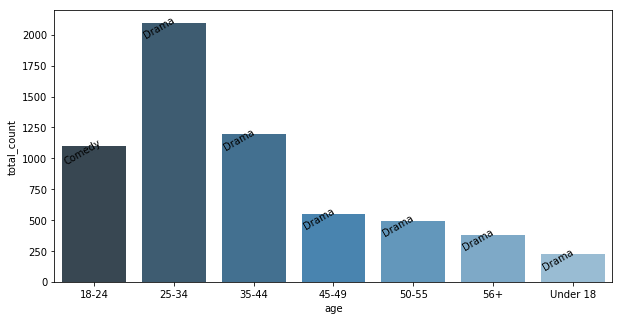

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
    
import matplotlib
%matplotlib inline 

plt.figure(figsize=(10, 5))

df = result.toPandas()
bar_graph = sb.barplot(data = df, x = 'age', y = 'total_count', ci = None, palette = 'Blues_d', order = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]);

i = 0
for p in bar_graph.patches:
    bar_graph.annotate(df.popular_genre[i] , xy=((p.get_x()), (p.get_height()*1)), rotation=30)
    i = i +1

In [9]:
result.coalesce(1).write.csv("hdfs://localhost:9000/MovieData/output/popular_genre_age_Pgroup.csv")
